In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from LTH_helper import LTH
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import initializers
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K


In [3]:
my_dataset = fashion_mnist

In [4]:
(train_images, train_labels), (test_images, test_labels) = my_dataset.load_data()
X = train_images.reshape(-1, 28, 28, 1)/255
y = train_labels.reshape(-1, 1)
X_test = test_images.reshape(-1, 28, 28, 1)/255
y_test = test_labels.reshape(-1, 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [26]:
def compile_model(model, lr=0.001):
    optim = optimizers.Adam(lr=lr)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
  
reduce = 1

def get_model(compile_model_flag=True, lr=0.001, activation='relu', reduce = reduce):
    input_dim=784
    output_size = 10
#     initializer = initializers.RandomNormal(mean=0, stddev=0.1)
    initializer = initializers.glorot_normal()
#     initializer = initializers.VarianceScaling(4.0, mode='fan_avg')
    # Creo el modelo
    
    model = Sequential()
    model.add(Conv2D(32, 3, input_shape=(28,28, 1), activation='relu'))
    # model.add(MaxPool2D(2))
    model.add(Conv2D(64, 3, activation=activation))
    model.add(MaxPool2D(2))
    model.add(Conv2D(128, 3, activation=activation))
    model.add(Conv2D(64, 3, activation=activation))
    #model.add(Conv2D(32, 3, activation=activation))
    model.add(Flatten())
    model.add(Dense(output_size, activation='softmax',
                    name='Salida', input_dim=input_dim,
                    kernel_initializer=initializer))
    if compile_model_flag:
        compile_model(model, lr=lr)
    return model
model = get_model()
# model.save_weights('random-init.hdf5')
model.summary()

Model: "sequential_198"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_289 (Conv2D)          (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_290 (Conv2D)          (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_142 (MaxPoolin (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_291 (Conv2D)          (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_292 (Conv2D)          (None, 8, 8, 64)          73792     
_________________________________________________________________
flatten_71 (Flatten)         (None, 4096)              0         
_________________________________________________________________
Salida (Dense)               (None, 10)             

In [27]:
def get_callbacks(filename):
    return [
        ReduceLROnPlateau(monitor='val_loss', mode='auto', factor=np.sqrt(0.1), patience=10, verbose=0, min_lr=1e-4),
        ModelCheckpoint(filepath=filename,  verbose=0, save_best_only=True, monitor='val_loss', mode='auto')
    ]

In [35]:
def train_model(activation='relu', epochs = 10, batch_size = 1024):
    model = get_model(activation=activation)
    # Save initial weights
    if type(activation) == str:
        initial_filename = f'mlp.mnist.initial_weights_{activation}.hdf5'
        best_filename = f'mlp.mnist.trained_weights_{activation}.hdf5'
    else:
        initial_filename = f'mlp.mnist.initial_weights_{activation.__name__}.hdf5'
        best_filename = f'mlp.mnist.trained_weights_{activation.__name__}.hdf5'
    model.save_weights(initial_filename)
    history = model.fit(X_train, 
               y_train,
               epochs=epochs, batch_size=batch_size, 
               validation_data = (X_val, y_val),
               verbose=2, 
               callbacks=get_callbacks(best_filename)
              )
    model.load_weights(best_filename)
    act = model.get_config()['layers'][0]['config']['activation']
    print(f'{act}: {model.evaluate(X_test, y_test, verbose=0)}')
    del model
    return history

Epoch 1/10
50/50 - 2s - loss: 0.9840 - accuracy: 0.6583 - val_loss: 0.6033 - val_accuracy: 0.7693 - lr: 0.0010
Epoch 2/10
50/50 - 2s - loss: 0.5174 - accuracy: 0.8059 - val_loss: 0.4522 - val_accuracy: 0.8348 - lr: 0.0010
Epoch 3/10
50/50 - 1s - loss: 0.4261 - accuracy: 0.8466 - val_loss: 0.4055 - val_accuracy: 0.8506 - lr: 0.0010
Epoch 4/10
50/50 - 1s - loss: 0.3813 - accuracy: 0.8633 - val_loss: 0.3802 - val_accuracy: 0.8632 - lr: 0.0010
Epoch 5/10
50/50 - 1s - loss: 0.3494 - accuracy: 0.8749 - val_loss: 0.3489 - val_accuracy: 0.8731 - lr: 0.0010
Epoch 6/10
50/50 - 2s - loss: 0.3219 - accuracy: 0.8847 - val_loss: 0.3216 - val_accuracy: 0.8832 - lr: 0.0010
Epoch 7/10
50/50 - 2s - loss: 0.3010 - accuracy: 0.8915 - val_loss: 0.3131 - val_accuracy: 0.8838 - lr: 0.0010
Epoch 8/10
50/50 - 2s - loss: 0.2812 - accuracy: 0.8991 - val_loss: 0.2939 - val_accuracy: 0.8931 - lr: 0.0010
Epoch 9/10
50/50 - 1s - loss: 0.2688 - accuracy: 0.9037 - val_loss: 0.2964 - val_accuracy: 0.8900 - lr: 0.0010
E

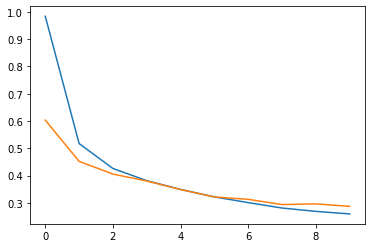

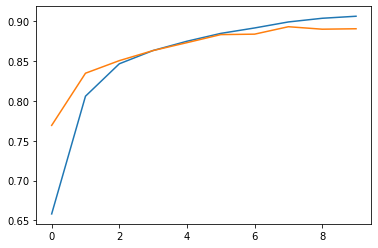

In [36]:
# activations = ['relu', 'sigmoid', 'tanh', 'softplus', 'softsign', 'selu', 'elu']
activations = ['relu']
for activation in activations:
    history = train_model(activation)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

In [37]:
initial_filename = f'mlp.mnist.initial_weights_{activation}.hdf5'
model.load_weights(initial_filename)
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 2.2978 - accuracy: 0.1099


[2.2977890968322754, 0.10989999771118164]

In [38]:
lth = LTH(get_model)

In [39]:
def get_untrained_curve(activation):
    pms = np.linspace(0.001, 0.999, 50)
    accs_nt = []
    best_acc = 0
    if type(activation) == str:
        initial_filename = f'mlp.mnist.initial_weights_{activation}.hdf5'
        best_filename = f'mlp.mnist.trained_weights_{activation}.hdf5'
    else:
        initial_filename = f'mlp.mnist.initial_weights_{activation.__name__}.hdf5'
        best_filename = f'mlp.mnist.trained_weights_{activation.__name__}.hdf5'
    for pm in pms:
        # Devuelve el modelo pruneado en funcion del entrenamiento
        model = get_model(activation=activation)    
        model.load_weights(best_filename)
        model_pruned_layers = lth.get_prunned_model(model, pm)
        # print(model_pruned_layers.get_config()['layers'][0]['config']['layer']['config']['activation'])
        # Coloca los pesos iniciales en los lugares sin prunear
        model.load_weights(initial_filename)
        model_pruned_layers_not_trained = lth.initialize_sparse_model(model, model_pruned_layers, pm)
        del model
        del model_pruned_layers
        # print(model_pruned_layers_not_trained.get_config()['layers'][0]['config']['layer']['config']['activation'])
        actual_acc = model_pruned_layers_not_trained.evaluate(X_test, y_test, verbose=0)[1]
        print(actual_acc, pm)
        if actual_acc>best_acc:
            best_acc = actual_acc
            best_pm = pm
            model_pruned_layers_not_trained_best = strip_pruning(model_pruned_layers_not_trained)
        accs_nt.append(actual_acc)
    np.save(f'acc_not_train_prunned_{activation}_relu_20_epochs_reduce_{reduce}_normal_glorot_50.npy', [pms, accs_nt])
    model_pruned_layers_not_trained_best.save_weights(f'best_untrained_acc_{activation}_{int(best_pm*1000)/10}_{int(best_acc*1000)/10}.hdf5')
    return pms, accs_nt, best_pm, best_acc

0.10000000149011612 0.001
0.10000000149011612 0.02136734693877551
0.10000000149011612 0.04173469387755102
0.14399999380111694 0.06210204081632653
0.10050000250339508 0.08246938775510204
0.27639999985694885 0.10283673469387755
0.32899999618530273 0.12320408163265306
0.3361000120639801 0.14357142857142857
0.3215000033378601 0.16393877551020408
0.4503999948501587 0.1843061224489796
0.4311000108718872 0.2046734693877551
0.4336000084877014 0.2250408163265306
0.4350000023841858 0.24540816326530612
0.47870001196861267 0.26577551020408163
0.4765999913215637 0.28614285714285714
0.5098999738693237 0.30651020408163265
0.48330000042915344 0.32687755102040816
0.5752000212669373 0.3472448979591837
0.5965999960899353 0.3676122448979592
0.5814999938011169 0.3879795918367347
0.607699990272522 0.4083469387755102
0.602400004863739 0.4287142857142857
0.5907999873161316 0.4490816326530612
0.5946000218391418 0.46944897959183673
0.6147000193595886 0.48981632653061224
0.6444000005722046 0.5101836734693878
0.6

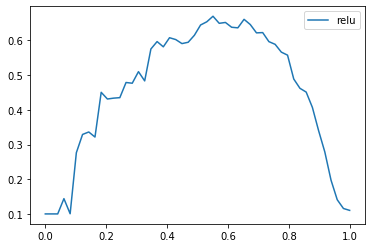

In [40]:
for activation in activations:
    pms, accs_nt, best_pm, best_acc = get_untrained_curve(activation)
    plt.plot(pms, accs_nt, label=f'{activation}')
    plt.legend()
    print(f'{activation}: {best_pm}, {best_acc}')